In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h2o

In [2]:
# data set cration

np.random.seed(2021)
n=5000

# independent variables
gender=['Female','Male']
d = pd.DataFrame({'gender':np.random.choice(gender, n)})

marital_status=['Single','Single','Single','Single','Married','Married','Married','Married','Divorced','Widowed']
d['marital_status']=[x for x in np.random.choice(marital_status,n)]

d['age']=[int(max(x,16)) for x in np.random.normal(50,15,n)]
d['distance']=[int(x) for x in np.random.chisquare(3,n)*10]
d['income']=[int(x) for x in np.random.lognormal(3,1,n)*1000]

# dependent variable calculation
d['number_of_visits']=1/d['distance']*10000+1/d['age']*1000+np.sqrt(d['income'])
d['number_of_visits'] = np.where((d['age'] < 30), d['number_of_visits']*2, d['number_of_visits']+20)
d['number_of_visits'] = np.where(d['gender']=='Male', d['number_of_visits']+d['distance'], d['number_of_visits']+d['age']/10)
# randomness addition
d['number_of_visits']=d['number_of_visits']+[int(x) for x in np.random.uniform(0,2000,n)]
d['number_of_visits']=(d['number_of_visits']/10).round(0)

# id
d.index.name='id'

In [3]:
d.head()

,gender,marital_status,age,distance,income,number_of_visits
id,,,,,,
0,Female,Married,29,29,35237,250.0
1,Male,Single,53,40,6496,186.0
2,Male,Divorced,52,6,26879,245.0
3,Female,Single,62,26,92467,111.0
4,Male,Married,56,47,13071,207.0


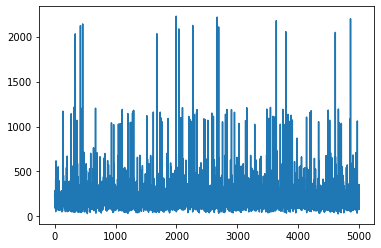

In [4]:
# target visualisation
plt.plot(d['number_of_visits'])

In [5]:
# h2o initialisation
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.11+9-LTS-194, mixed mode)
  Starting server from C:\Users\Gerd\venvs\h2o\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Gerd\AppData\Local\Temp\tmpmces0tde
  JVM stdout: C:\Users\Gerd\AppData\Local\Temp\tmpmces0tde\h2o_Gerd_started_from_python.out
  JVM stderr: C:\Users\Gerd\AppData\Local\Temp\tmpmces0tde\h2o_Gerd_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_Gerd_1iryoa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.975 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
# data import
d=h2o.H2OFrame(d)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# data split
train, valid, test = d.split_frame(ratios=[0.7,0.15],seed=19)

In [8]:
y='number_of_visits'
x=d.columns[:5]
x

['gender', 'marital_status', 'age', 'distance', 'income']

In [9]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [10]:
# reasonable gbm model
mgbm = H2OGradientBoostingEstimator(nfolds=10,ntrees=45,max_depth=4, )
mgbm.train(x,y,train,model_id='first',validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
# results on training and testing data
print(mgbm.model_performance(train=True))
print(mgbm.model_performance(test))


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3290.701993660183
RMSE: 57.36464062172954
MAE: 48.92555435625857
RMSLE: 0.3644010356692234
Mean Residual Deviance: 3290.701993660183


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 4066.986503056774
RMSE: 63.77292923378049
MAE: 51.95264106980037
RMSLE: 0.3725840886403885
Mean Residual Deviance: 4066.986503056774



In [12]:
# overfitted gbm model
mgbm2 = H2OGradientBoostingEstimator(ntrees=500,nfolds=10,max_depth=10)
mgbm2.train(x,y,train,model_id='overfit',validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [14]:
# results on training and testing data
print(mgbm2.model_performance(train=True))
print(mgbm2.model_performance(test))


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 558.3402763139162
RMSE: 23.629225046833767
MAE: 18.497452692254456
RMSLE: 0.16515857153581098
Mean Residual Deviance: 558.3402763139162


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 4855.748982038423
RMSE: 69.68320444725848
MAE: 55.87194096416413
RMSLE: 0.40800666984702333
Mean Residual Deviance: 4855.748982038423

